# 音源の再合成

In [28]:
#綺麗に描き直してユーティリティー関数に入れる

def _scw2spectrum(x,duplicate_num=6):

    """波形を6つくっつけてSTFTする関数

    Args:
        x (torch.Tensor): [description]
        duplicate_num (int, optional): [description]. Defaults to 6.
    Returns:
        tmp (torch.Tensor): [description]
    """

    batch_size = len(x[:])
    for i in range(batch_size):
        single_channel_scw = x[i,:,:] #[32,1,600] -> [1,1,600]

        if i == 0:
            tmp = _scw_combain_spec(single_channel_scw,duplicate_num) #[901,1]
        else:
            tmp = torch.cat([tmp, _scw_combain_spec(single_channel_scw,duplicate_num)]) #[901*i,1]

    #combain_spec = tmp.reshape(batch_size,-1) # [32,901,1]??
    return tmp

再構成データのスペクトラム


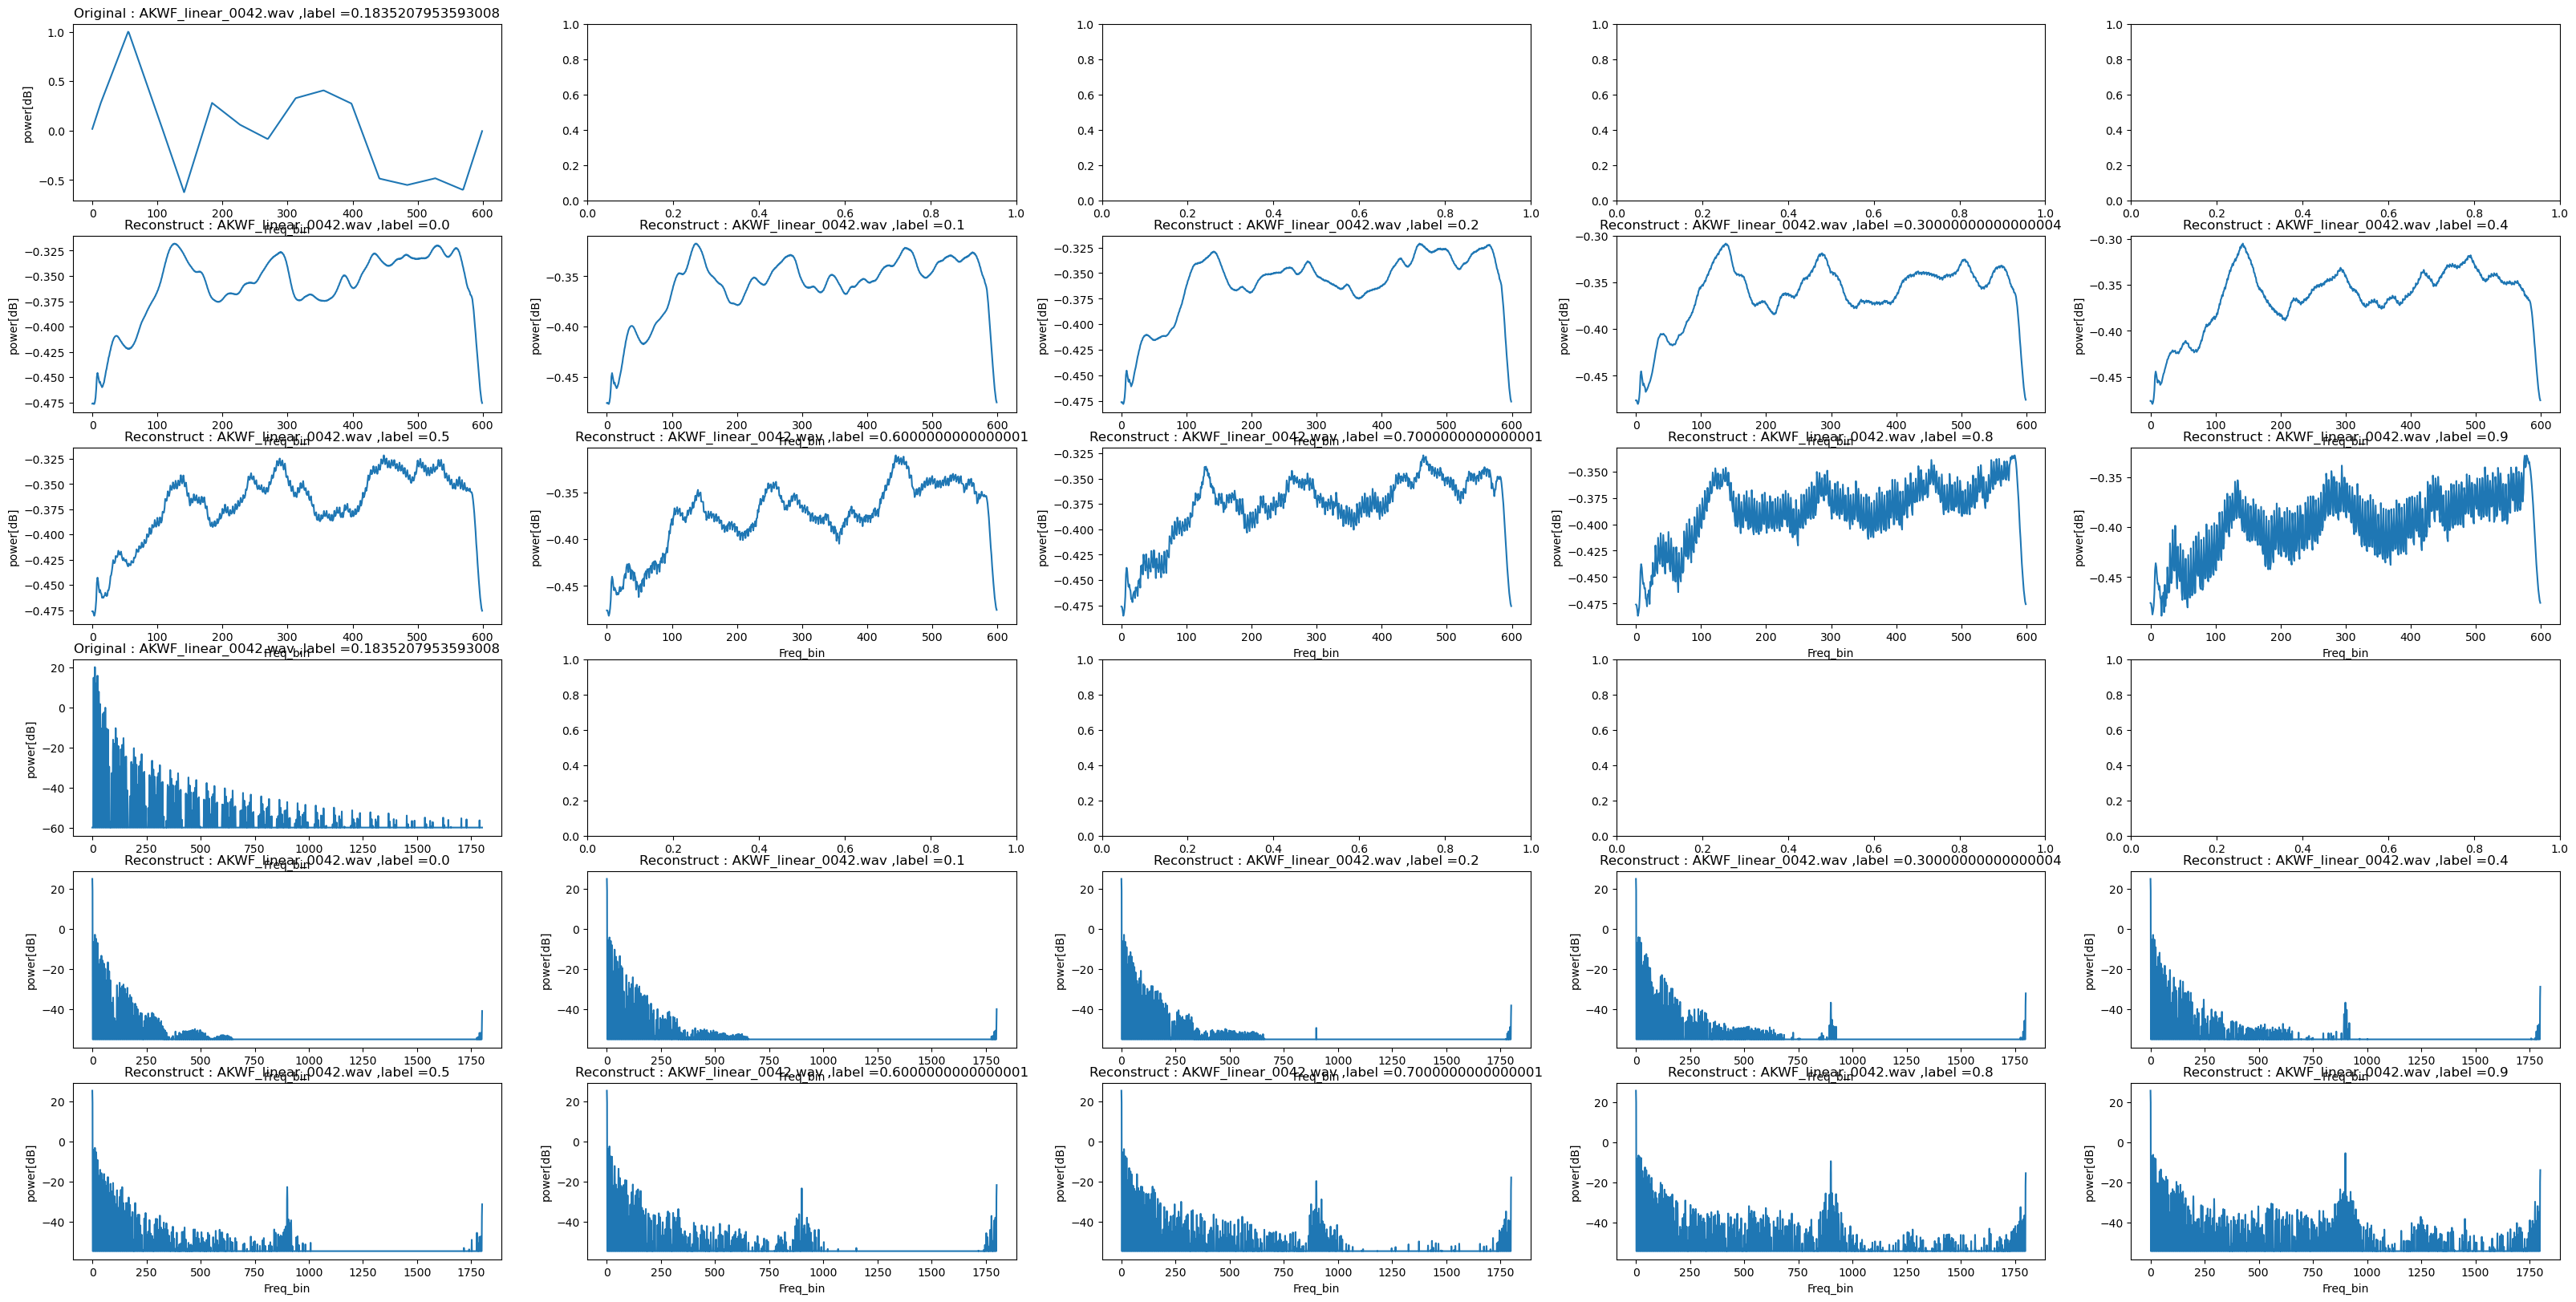

In [135]:
nrows = 4
ncols = 5
idx = 3

def plot_all(x,attrs,i,me):
  axs[i//ncols, i%ncols].set_title( me + " : " + attrs['name'] + " ,label =" + str(attrs['SpectralCentroid']))
  axs[i//ncols, i%ncols].set_xlabel("Freq_bin")
  axs[i//ncols, i%ncols].set_ylabel("power[dB]")
  axs[i//ncols, i % ncols].plot(x.cpu())


# 再構成した明るさを変えていく
fig, axs = plt.subplots(nrows=nrows+2, ncols=ncols, figsize=(40,20))
fig.patch.set_facecolor("white")
for i in range(10):
  if i >= 10: break
  else:
    if i == 0:
      x, attrs = dm.train_dataset[idx]
      me = "Original"
      plot_all(x[0],attrs,i,me)
      x = _scw_combain_spec(x,6)[0]
      plot_all(x,attrs,i+15,me)

    x, attrs = dm.train_dataset[idx]
    #attrs['brightness'] = (100 / 10) * i
    attrs['SpectralCentroid'] = (1 / 10) * i
    me = "Reconstruct"
    x = x.unsqueeze(0)
    _, _, x = model_eval(x,attrs,model,latent_op)
    plot_all(x[0,0],attrs,i+5,me)
    x = _scw_combain_spec(x,6)[0]
    plot_all(x,attrs,i+20,me)

print("再構成データのスペクトラム")

## 確認用に簡易的なWavetable Synthを作ろう

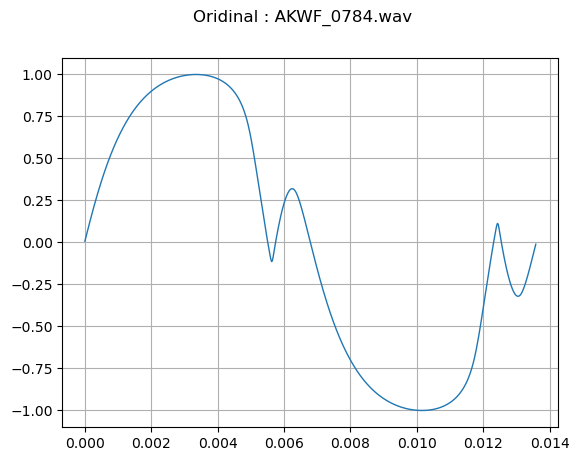

default_brightness 41.812464663505786
0


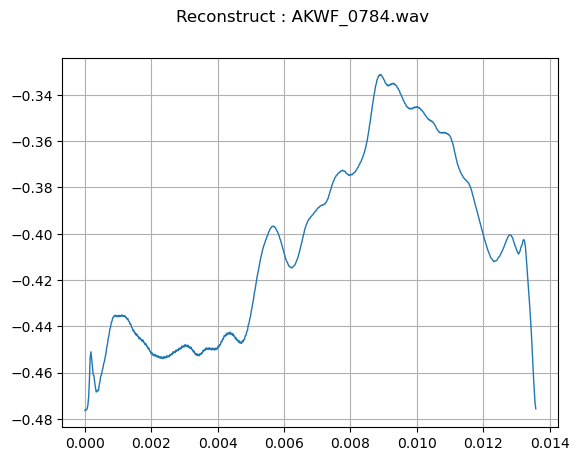

20


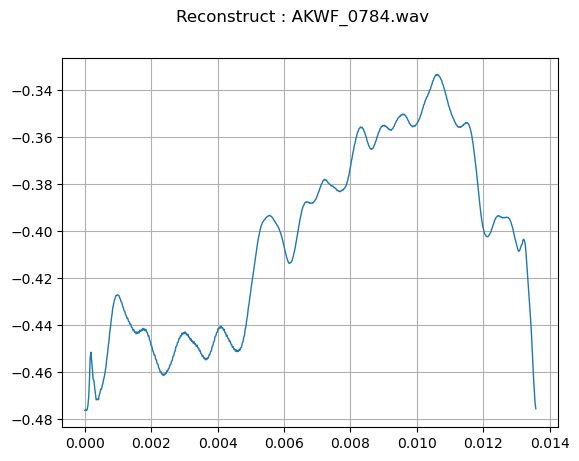

40


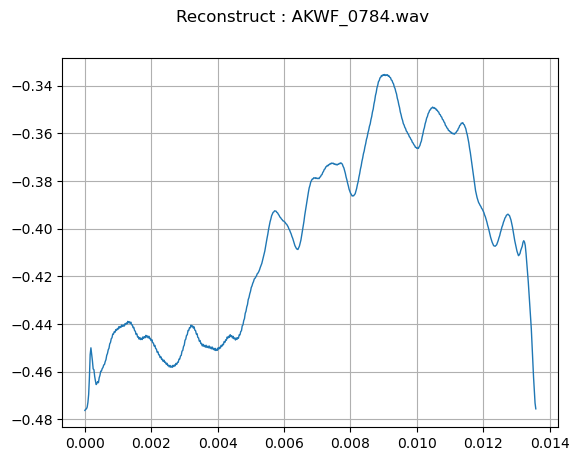

60


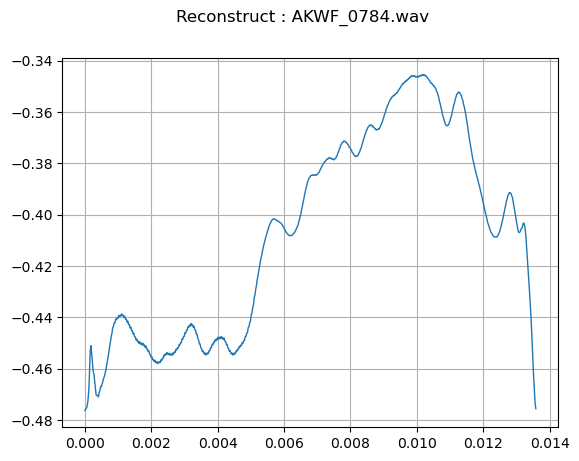

80


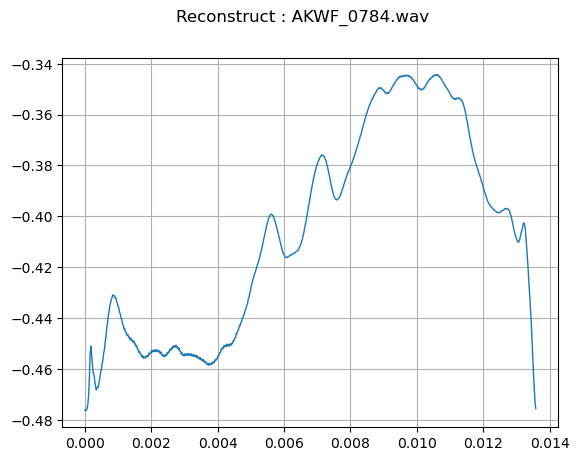

In [138]:
#wavetable, attrs = dm.test_dataset[random.randint(0,len(dm.train_dataset))]
wavetable, attrs = dm.test_dataset[0]
plot_waveform(wavetable, attrs["samplerate"], title="Oridinal : " + attrs["name"])
print("default_brightness",attrs['brightness'])

for i in np.arange(0, 100, 20):
    attrs['brightness'] = i
    #attrs['roughness'] = i
    #attrs['depth'] = i
    _, _, predict_wavetable = model_eval(wavetable.unsqueeze(0),attrs,model,latent_op)
    predict_wavetable = predict_wavetable.cpu()
    print(attrs['brightness'])
    plot_waveform(predict_wavetable[0], attrs["samplerate"], title="Reconstruct : " + attrs["name"])
    audio = wavetableSynth(predict_wavetable, sample_rate, duration, frequency, amplitude, start_phase)
    display(Audio(audio, rate=sample_rate))
    

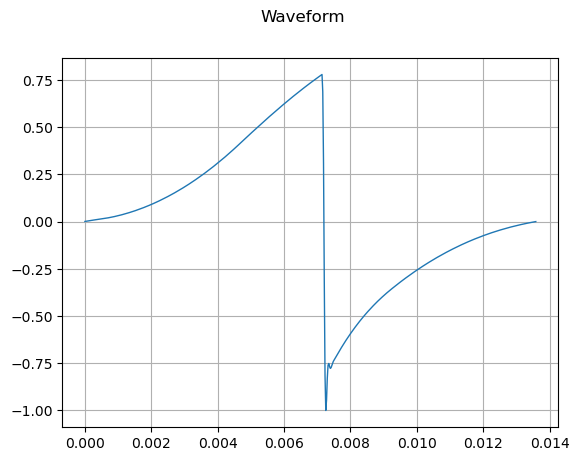

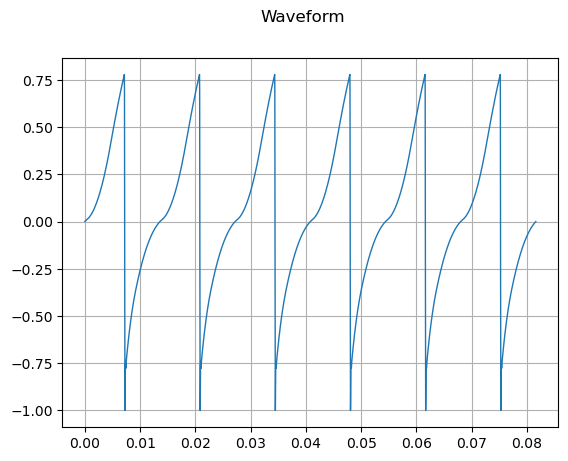

torch.Size([1, 3600])
torch.Size([1801, 1])
1


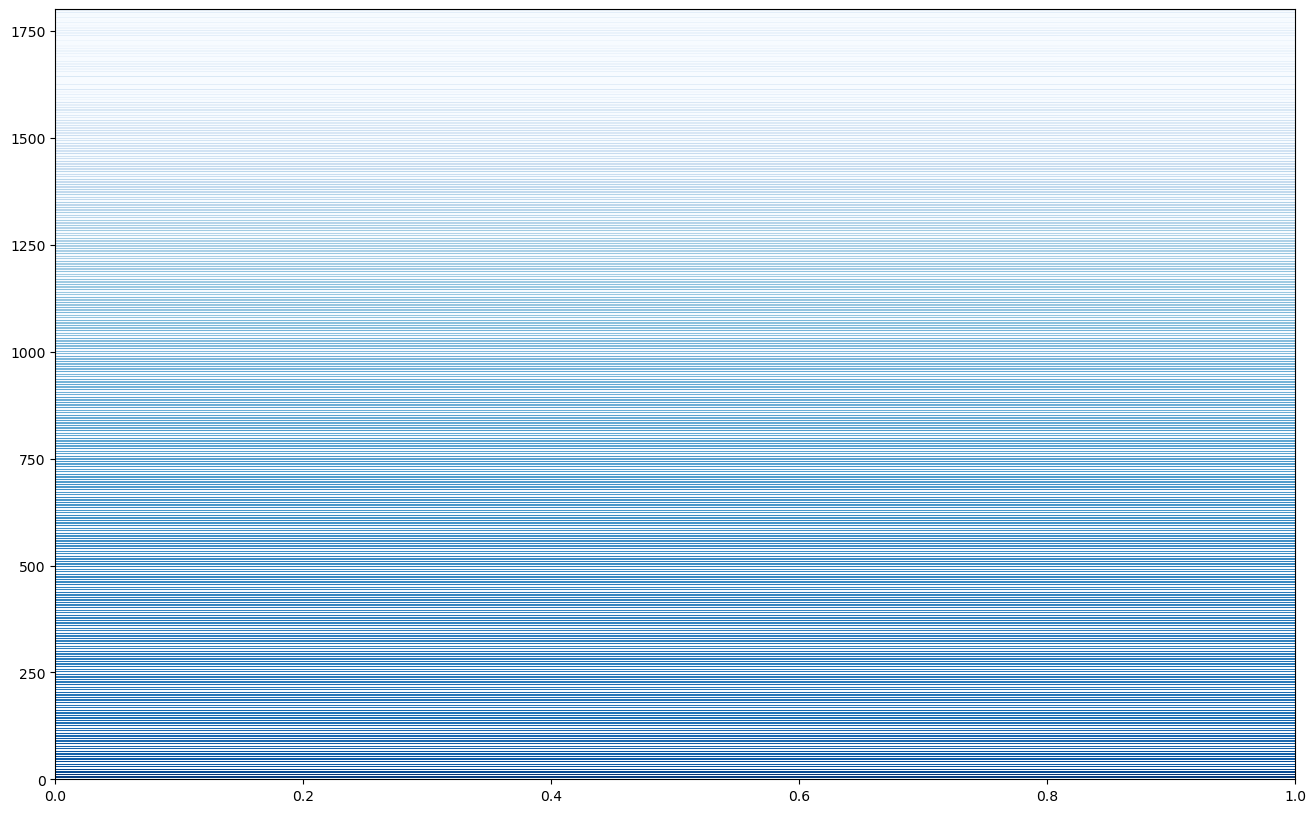

In [139]:
#ちゃんとどのような挙動になっているか確認する

# 波形を6つくっつけてSTFTする
copy_count = 6

#wavetable, attrs = dm.train_dataset[random.randint(0,len(dm.train_dataset))]
wavetable, attrs = dm.train_dataset[0]

#print(wavetable.shape)
plot_waveform(wavetable, attrs["samplerate"])

#wavetable = torch.randn(32,1,600)
#print(len(wavetable[:]))
#batch_size = len(wavetable[:])

#wavetable = wavetable.reshape(batch_size, -1)
# indices for the wavetable values; this is just for `np.interp` to work
wavetable_period = len(wavetable[0,:])

tmp_wavetable = wavetable

for i in range(copy_count-1):
    tmp_wavetable = torch.cat([tmp_wavetable,  wavetable])
    #print(i)
combain_wavetables = tmp_wavetable.reshape(1, -1)
plot_waveform(combain_wavetables, attrs["samplerate"])

print(combain_wavetables.shape)


spec = torchaudio.transforms.Spectrogram(
                                         n_fft = int(wavetable_period*(copy_count)),
                                         hop_length = int(wavetable_period*(copy_count)),
                                         win_length = int(wavetable_period*(copy_count)),
                                         center=False,
                                         pad=0,
                                         window_fn = torch.hann_window,
                                         normalized=True,
                                         onesided=True,
                                         #return_complex = True,
                                         power=2.0)

ToDB = torchaudio.transforms.AmplitudeToDB()


spec_wavetable = ToDB(spec(combain_wavetables).abs())
spec_wavetable =spec_wavetable[0]
print(spec_wavetable.shape)
print(len(spec_wavetable[0]))
#spec_wavetable = spec_wavetable[0,:901,1:-1]
#print(spec_wavetable.shape)

plt.figure(figsize=(16,10))
plt.pcolor(spec_wavetable, cmap=plt.cm.Blues)

In [140]:
import torch

def waveToSpec(waveform: torch.Tensor, sample_points: int, db:bool ):
    spec =  torchaudio.transforms.Spectrogram(
                                                       n_fft = sample_points, #時間幅
                                                       hop_length = sample_points, #移動幅
                                                       win_length = sample_points, #窓幅
                                                       center=False,
                                                       pad=0, #no_padding
                                                       window_fn = torch.hann_window,
                                                       normalized=True,
                                                       onesided=True,
                                                       power=1.0)
        
    ToDB =  torchaudio.transforms.AmplitudeToDB(stype = 'magnitude')#,top_db = 50)
    combain_x = waveform.reshape(1, -1) # [3600] -> [1,3600]
    spec_x = spec(combain_x.to('cpu')) # [1,3600] -> [901,1???]
    #print(spec_x.shape)
    if db:
        spec_x = ToDB(spec_x)

    return spec_x